# supernode-features

The procedure of constructing supernode features of various kinds.

__Warning!__ Some procedures require 16 cores and up to 5 GB RAM.

Requires:
1. `data/supernodes/supernode_attributes.json`
2. `data/supernodes/edges_pspace.json`
3. `data/supernodes/supernodes.json`

Produces:
1. `data/features/infrastructure_features.json`
2. `data/features/graph_features.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from itertools import chain, product
from multiprocessing import Pool

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.stats import corrcoef
from myutils.json import save_json, load_json

from config import supernode_attributes_fpath, edges_pspace_fpath, supernodes_fpath, \
    infrastructure_features_fpath, graph_features_fpath

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-deep')

In [3]:
supernode_attributes = pd.read_json(supernode_attributes_fpath).set_index('id')

supernode_attributes.head(2)

,residential,shop,restaurant,service,medicine,education_research,tourism,sport,car_related,company,administrative,supermarket,hotel_business,industrial,bank_and_money,printing_and_books,post_office,religion,business_center_or_mall_or_marketplace,theatre_cinema
id,,,,,,,,,,,,,,,,,,,,
0,141,149,74,43,46,21,14,33,5,5,8,13,3,2,27,13,4,0,0,0
1,111,114,108,42,51,33,41,13,6,9,18,6,13,6,7,9,4,7,1,0


In [4]:
edges = load_json(edges_pspace_fpath)

edges[:5]

[{'u': 0, 'v': 6, 'w': 23.28185292299166, 'route': 10003},
 {'u': 0, 'v': 8, 'w': 14.863275410682126, 'route': 2871},
 {'u': 0, 'v': 9, 'w': 13.995378725186596, 'route': 2871},
 {'u': 0, 'v': 13, 'w': 10.92823404394134, 'route': 1135},
 {'u': 0, 'v': 14, 'w': 12.609849731838038, 'route': 1085}]

In [5]:
pspace = nx.Graph()

for edge in edges:
    pspace.add_edge(edge['u'], edge['v'], weight=edge['w'], route=edge['route'])

len(pspace), len(pspace.edges)

(3202, 118449)

In [6]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


## Infrastructure features

In [7]:
infrastructure_features = supernode_attributes.copy()

In [8]:
total = infrastructure_features.sum(axis=1)

mask = (total > 0)
infrastructure_features[mask] = infrastructure_features[mask].divide(total[mask], axis=0)
infrastructure_features['total'] = total

# infrastructure_features['total'] = np.log(1 + infrastructure_features['total'])

infrastructure_features.head(2)

,residential,shop,restaurant,service,medicine,education_research,tourism,sport,car_related,company,...,supermarket,hotel_business,industrial,bank_and_money,printing_and_books,post_office,religion,business_center_or_mall_or_marketplace,theatre_cinema,total
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0,601
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0,599


/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


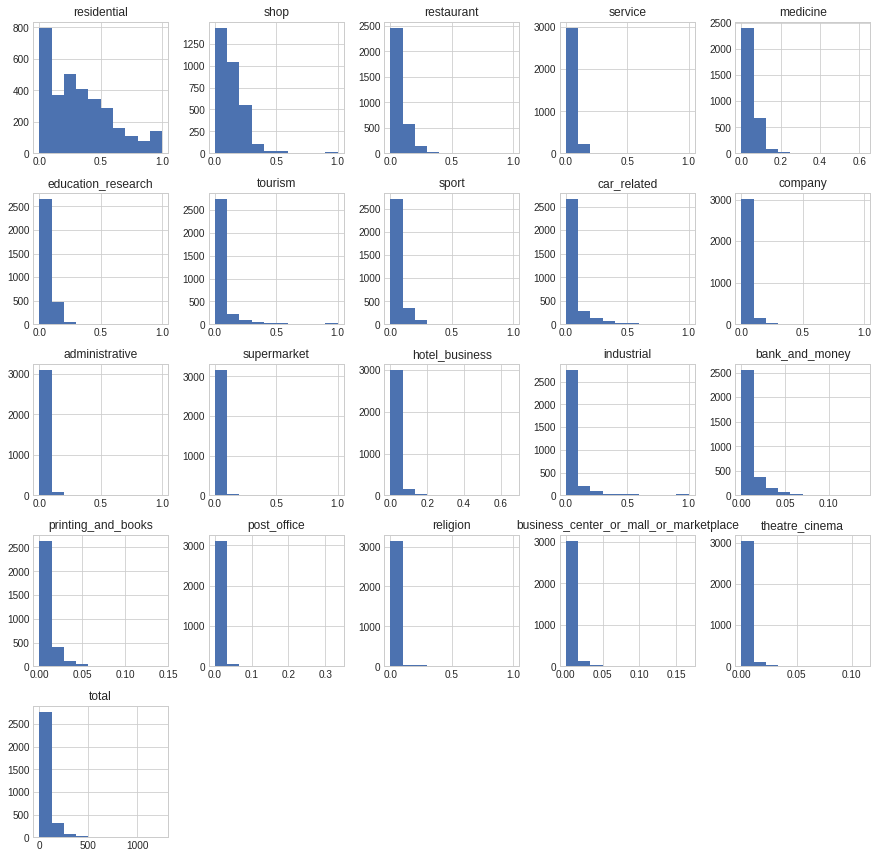

In [9]:
infrastructure_features.hist(figsize=(15, 15));

<AxesSubplot:>

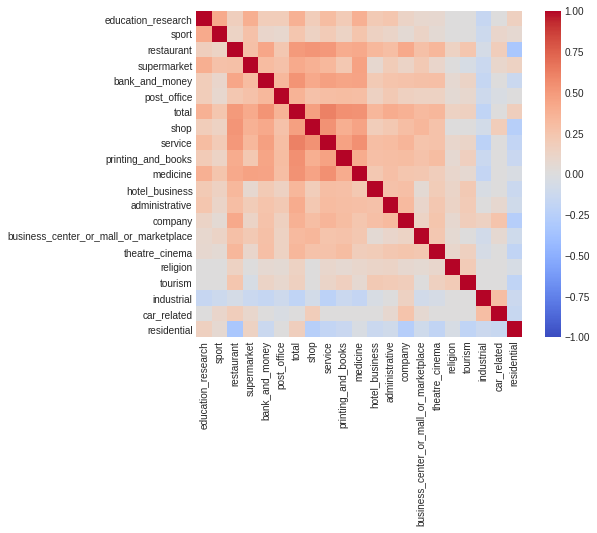

In [10]:
plt.figure(figsize=(8, 6))

corr = corrcoef(infrastructure_features, method='spearman').fillna(0)

sns.heatmap(corr, vmin=-1, cmap='coolwarm', square=True)

In [11]:
total = infrastructure_features['total']

total.head(2)

id
0    601
1    599
Name: total, dtype: int64

In [12]:
quantiles = total.quantile([0, 0.3, 0.5, 0.8, 1])
quantiles

0.0       0.0
0.3      25.0
0.5      48.0
0.8     103.0
1.0    1254.0
Name: total, dtype: float64

In [13]:
def assign_size_cluster(value: float) -> str:
    for i, q in enumerate(quantiles):
        if value <= q:
            return i

size_clusters = total.apply(assign_size_cluster)

size_clusters.head(2)

id
0    4
1    4
Name: total, dtype: int64

In [14]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.3224152 , 59.85170995],
       [30.28793738, 59.95020979],
       [30.35401882, 59.95671589],
       ...,
       [30.3595223 , 59.9445053 ],
       [30.2344264 , 59.94853172],
       [30.21190075, 59.97198015]])

Text(0.5, 1.0, 'Nodes with different number of attached infrastructure objects')

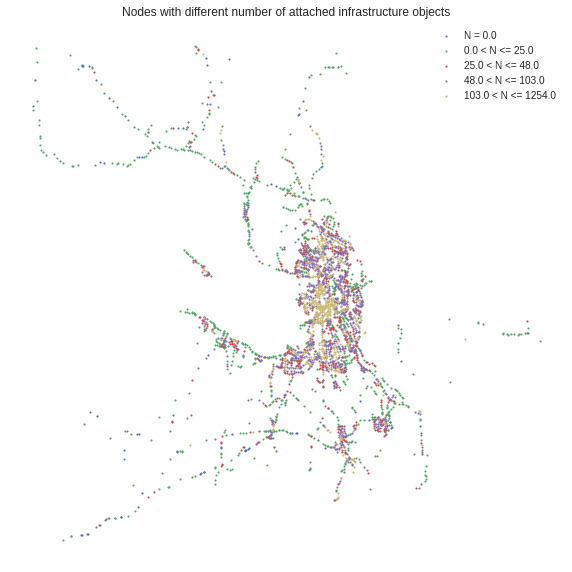

In [15]:
plt.figure(figsize=(10, 10))
plt.axis('off')

for i in sorted(size_clusters.unique()):
    cluster_coords = coords[size_clusters == i]
    
    if i == 0:
        label = f'N = {quantiles.iloc[i]}'
    else:
        label = f'{quantiles.iloc[i - 1]} < N <= {quantiles.iloc[i]}'
        
    plt.scatter(*cluster_coords.T, color=f'C{i}', marker='.', s=5, label=label)

plt.legend()
plt.title('Nodes with different number of attached infrastructure objects')

In [16]:
infrastructure_features_json = []

for _, row in infrastructure_features.reset_index().iterrows():
    row = row.to_dict()
    row['id'] = int(row['id'])
    infrastructure_features_json.append(row)

In [17]:
save_json(infrastructure_features_json, infrastructure_features_fpath)

## Graph features

<AxesSubplot:>

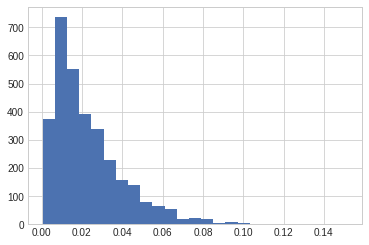

In [18]:
degree_centrality = pd.Series(nx.degree_centrality(pspace))

degree_centrality.hist(bins=25)

In [19]:
def chunks(l, n):
    return [tuple(l[i : i + n]) for i in range(0, len(l), n)]

In [20]:
def betweenness_centrality_parallel(G, processes=16):
    p = Pool(processes=processes)
    
    node_divisor = len(p._pool) * 4
    node_chunks = chunks(list(G.nodes()), int(G.order() / node_divisor))
    num_chunks = len(node_chunks)
    
    betweenness_centrality_chunks = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            ['weight'] * num_chunks,
        ),
    )
    
    betweenness_centrality = betweenness_centrality_chunks[0]
    
    for betweenness_centrality_chunk in betweenness_centrality_chunks[1:]:
        for n in betweenness_centrality_chunk:
            betweenness_centrality[n] += betweenness_centrality_chunk[n]
        
    p.close()

    return betweenness_centrality

CPU times: user 3.01 s, sys: 258 ms, total: 3.27 s
Wall time: 42.6 s


<AxesSubplot:>

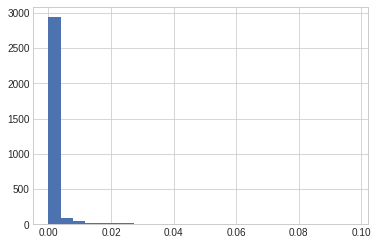

In [21]:
%%time

betweenness_centrality = pd.Series(betweenness_centrality_parallel(pspace))

betweenness_centrality.hist(bins=25)

In [22]:
def single_source_dijkstra_path_length_subset(g, subset):
    return {
        node: dict(nx.single_source_dijkstra_path_length(pspace, node, weight='weight'))
        for node in subset
    }

In [23]:
def shortest_path_lengths_parallel(G, processes=16):
    p = Pool(processes=processes)
    
    node_divisor = len(p._pool) * 4
    node_chunks = chunks(list(G.nodes()), int(G.order() / node_divisor))
    num_chunks = len(node_chunks)
    
    shortest_path_lengths_chunks = p.starmap(
        single_source_dijkstra_path_length_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
        ),
    )
    
    shortest_path_lengths = shortest_path_lengths_chunks[0]
    
    for shortest_path_lengths_chunk in shortest_path_lengths_chunks[1:]:
        shortest_path_lengths.update(shortest_path_lengths_chunk)
        
    p.close()

    return shortest_path_lengths

In [24]:
%%time

shortest_path_lengths = pd.DataFrame(shortest_path_lengths_parallel(pspace))

shortest_path_lengths.head(2)

CPU times: user 5.24 s, sys: 842 ms, total: 6.08 s
Wall time: 32.6 s


,0,6,8,9,13,14,15,16,19,21,...,2916,2917,2033,2034,2035,2036,2037,2038,3090,3091
0,0.000000,23.069443,13.624203,13.347050,6.194128,11.546631,7.649407,7.163426,2.690249,13.125936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,0.461312,23.530756,14.085515,13.808362,6.655440,12.007943,7.209116,7.624739,3.144753,13.587248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
def closeness_centrality(shortest_path_lengths: pd.DataFrame) -> pd.Series:
    N = shortest_path_lengths.shape[0]
    n = shortest_path_lengths.notna().sum(axis=0)
    
    d = shortest_path_lengths.sum(axis=0)
    d[d == 0] = 1
    
    return (n - 1) ** 2 / ((N - 1) * d)

<AxesSubplot:>

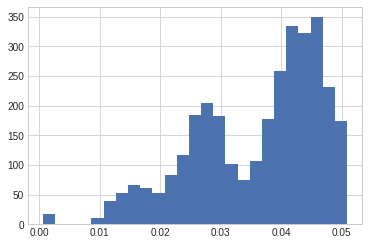

In [26]:
closeness_centrality = closeness_centrality(shortest_path_lengths.T)

closeness_centrality.hist(bins=25)

In [27]:
graph_features = pd.DataFrame({
    'betweenness_centrality': betweenness_centrality,
    'closeness_centrality': closeness_centrality,
    'degree_centrality': degree_centrality,
    # 'pagerank': pagerank,
    # 'clustering': clustering,
    # 'eigenvector_centrality': eigenvector_centrality,
})

graph_features.index.name = 'id'

graph_features.head(2)

,betweenness_centrality,closeness_centrality,degree_centrality
id,,,
0,0.070812,0.046982,0.124024
1,0.087949,0.049458,0.078101


In [28]:
graph_features.isna().any().any()

False

In [29]:
for col in list(graph_features.columns):
    values = graph_features[col]
    
    neighbour_mean = {}
    
    for node in pspace:
        neighbours = set(pspace.neighbors(node))
        mean = values[neighbours].mean()
        neighbour_mean[node] = mean
    
    neighbour_mean = pd.Series(neighbour_mean)    
    neighbour_mean.index.name = 'id'
    
    graph_features[col + '_neighbour_mean'] = neighbour_mean
    
graph_features.isna().any().any()

False

<AxesSubplot:>

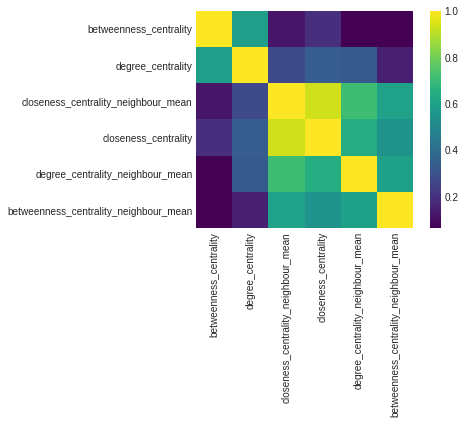

In [30]:
corr = corrcoef(graph_features, method='spearman').fillna(0)

sns.heatmap(corr, square=True, cmap='viridis')

In [31]:
graph_features_json = []

for i, row in graph_features[sorted(graph_features.columns)].iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    
    graph_features_json.append(item)
    
graph_features_json[0]

{'id': 0,
 'betweenness_centrality': 0.0708123710928476,
 'betweenness_centrality_neighbour_mean': 0.0047093065785512485,
 'closeness_centrality': 0.046981632619449105,
 'closeness_centrality_neighbour_mean': 0.042130804264725125,
 'degree_centrality': 0.1240237425804436,
 'degree_centrality_neighbour_mean': 0.03709010959264146}

In [32]:
save_json(graph_features_json, graph_features_fpath)